## Time Signature Detection by Using a Multi- Resolution Audio Similarity Matrix
#### from [1] M. Gainza and E. Coyle, “Time Signature Detection by Using a Multi-Resolution Audio Similarity Matrix,” AES 122nd Conv., no. September 2004, p. 8, 2007.

#### Import necessary modules and set some global variables

In [15]:
import essentia.standard as estd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform
from collections import OrderedDict
import csv
import pandas as pd
import xml.etree.ElementTree as ET

audioInput = 0
bpm = 0
fs = 0
path_to_data_set = '../mp3/'
path = '../mp3/0/american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-0-29.mp3'

#### Function definition to extract tempo estimation and read audio from file (plus any downmixing and/or upsampling as needed)

Essentia's standard mode algorithms are employed throughout, the most important of which for the presented algorithm is the tempo estimator PercivalBpmEstimator.

In [16]:
def get_audio_and_tempo(path):    
    loader = estd.AudioLoader(filename=path)
    downmixer = estd.MonoMixer()
    audioInput = loader()
    tempAudioInput, fs, num_channels, md5, bit_rate, codec = loader()
    audioInput = downmixer(tempAudioInput, num_channels)
    tempo_estimation_algo = estd.PercivalBpmEstimator(maxBPM=250, minBPM=40, sampleRate=int(fs))
    bpm = tempo_estimation_algo(audioInput)
    print(bpm, 'bpm, ', fs, 'Hz')
    return audioInput, bpm, fs

#### Compute spectrogram, and 2-band energy for first note detection:
As specified in section 2.1 of the paper, the first step in the algorithm is to compute the spectrogram with a frame size of a fraction of the song's beat duration, calculated based on the given tempo estimation in bpm. Also, the first note of the song is calculated at this point (to be used later in the creation of the ASM), through a simple ratio between the spectral energies of two spectrogram bands.

However, we find several issues with this first note detection algorithm, as implemented by Gainza & Coyle:
- The threshold Tn [1], energy_threshold, is difficult to adjust. What would constitute a "high threshold Tn"? From our trials, this may vary from a value of 500 up to 100000, depending on the noise contents and sampling rate of the audio file.
- The authors point to [Amatriain, X., et al., Spectral Processing, In Proc Digital Audio Effects, DAFX. 2002, John Wiley & Sons. Chapter 10.] as the source for their first note detection algorithm. However, Amatriain et al. (p. 54) propose an attack detection method based on relative energy changes (i.e. how fast is energy in a given band changing at frame s, not a mere energy quotient as proposed by Gainza & Coyle), calculated as: 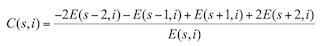
where s is a frame, E is spectral energy, and i is a frequency band index
- The authors provide a confusing explanation for the proposed methods, so there was a considerable amount of guess-work in implementing the algorithm parts as stated in the paper. Where the quotient E1/E2 would have to be greater than the threshold, they write: 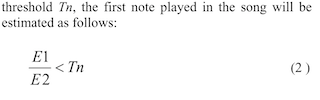

In [17]:
def compute_spectrogram(path):
    ## var init
    beat_duration = (60/bpm)*fs  # in samples
    frame_size = int(round(beat_duration/32))
    hop_size = round(frame_size/2)
    fft_size = int(np.power(2, np.ceil(np.log2(frame_size))))
    padding_size = fft_size - frame_size
    band1 = (1, 3000)
    if fs == 16000.0: # assuming fs is either going to be 16000 or 44100 and not any other value.
        band2 = (5443, 7619)
    elif fs == 44100.0:
        band2 = (15000, 21000)
    energy_threshold = 500.0    # the 1st energy_ratio value above this will be understood as first note in audio file

    ## get necessary Essentia algorithms
    window_algo = estd.Windowing(normalized=True, size = frame_size, type = 'hann', zeroPadding = padding_size)
    fft_algo = estd.FFT(size = fft_size)
    energy1_algo = estd.EnergyBand(sampleRate=fs, startCutoffFrequency=band1[0], stopCutoffFrequency=band1[1])
    energy2_algo = estd.EnergyBand(sampleRate=fs, startCutoffFrequency=band2[0], stopCutoffFrequency=band2[1])


    spectrogram = []
    db_spectrogram = []
    print('Frame Size:', frame_size)
    print('FFT Size:', fft_size)
    print('Padding length:', padding_size)

    first_note_flag = None
    for index, frame in enumerate(estd.FrameGenerator(audioInput, frameSize = frame_size, hopSize = hop_size, startFromZero = True)):
        ## spectrogram
        windowed_frame = window_algo(frame)
        mX = abs(fft_algo(windowed_frame))
        mX[mX<np.finfo(float).eps] = np.finfo(float).eps    # if zeros add epsilon to handle log
        dbX = 20 * np.log10(mX)
        spectrogram.append(np.array(mX))
        db_spectrogram.append(np.array(dbX))

        # energies and first note location
        energy1 = energy1_algo(mX)
        energy2 = energy2_algo(mX)
        energy_ratio = energy1/energy2
        if (first_note_flag == None) and (energy_ratio > energy_threshold):
            first_note_flag = index
            print("Found first note for frame with E1=", energy1, ", E2=", energy2, ", and E1/E2=", energy_ratio)
    spectrogram = np.array(spectrogram)
    db_spectrogram = np.array(db_spectrogram)
    print('Spectrogram done. Size is (axis1, axis2):', spectrogram.shape)
    return spectrogram, db_spectrogram, fft_size, hop_size, first_note_flag

#### Plot Spectrogram - This is for visual feedback only, so that the data being manipulated is clear to the reader, as well as stating some spectral analysis parameters:

101.83189392089844 bpm,  44100.0 Hz
Frame Size: 812
FFT Size: 1024
Padding length: 212
Found first note for frame with E1= 0.02448374778032303 , E2= 6.022356956236763e-06 , and E1/E2= 4065.4760184827
Spectrogram done. Size is (axis1, axis2): (3294, 513)


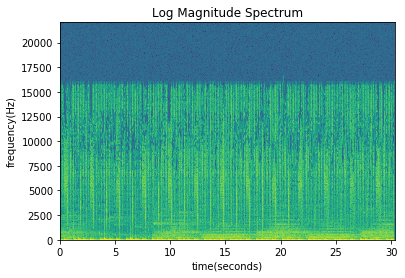

In [18]:
full_path = path_to_data_set + path
audioInput, bpm, fs = get_audio_and_tempo(full_path)
spectrogram, db_spectrogram, fft_size, hop_size, first_note_flag = compute_spectrogram(full_path)


timeAxSec=np.arange(db_spectrogram.shape[0])*hop_size/float(fs)
freqAx_normalized=np.arange(db_spectrogram.shape[1])/float(fft_size)    #Normalized frequency axis
freqAxHz=float(fs)*freqAx_normalized

plt.pcolormesh(timeAxSec,freqAxHz,np.transpose(db_spectrogram))
plt.xlim([0,timeAxSec[-1]])
plt.ylim([0,freqAxHz[-1]])
plt.title('Log Magnitude Spectrum')
plt.ylabel('frequency(Hz)')
plt.xlabel('time(seconds)')
plt.show()

Just for reference, to enable checking first note detection against the file in a wave editor. However, this is usually not accurate. In any case, we have found that it is the initial tempo estimation that affects the algorithm's results most (since that determines analysis frame sizes), more than the first note detection system.

In [19]:
## time(sec) of found first note
print('First note found at time:', first_note_flag*hop_size/fs, 'seconds')

First note found at time: 0.018412698412698412 seconds


#### Audio Similarity Matrices (ASMs):

Here we demonstrate the main principle underlying the algorithm presented by Gainza & Coyle. The second line of code takes the spectrogram frames starting at the first note position, and computes pair-wise euclidian distance between spectrogram frames. This is the starting point in the main function compute_similarity().

Frame Size: 812
FFT Size: 1024
Padding length: 212
Found first note for frame with E1= 0.02448374778032303 , E2= 6.022356956236763e-06 , and E1/E2= 4065.4760184827
Spectrogram done. Size is (axis1, axis2): (3294, 513)


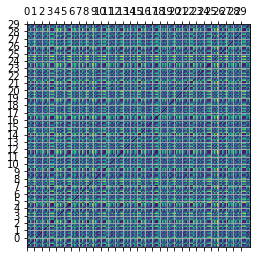

In [20]:
spectrogram, db_spectrogram, fft_size, hop_size, first_note_flag = compute_spectrogram(path)
ref_ASM = squareform(pdist(spectrogram[first_note_flag:]))

labels = list(range(int(len(audioInput)/fs)))
plt.matshow(ref_ASM[::-1])
stride = list(np.multiply(fs/hop_size, labels))
plt.xticks(stride, labels)
plt.yticks(stride, labels[::-1])
plt.grid(True)

#### Considered bar lengths:
These range from 2 to 12 beats in a bar, calculated as multiples of beat_duration

In [21]:
bar_candidates = np.multiply(64, list(range(2, 13)))

#### Diagonal processing:
For any given ASM, its diagonals (which represent points of similarity across the audio file at different offsets) are taken and fragmented into segments of various lengths, covering all considered bar lengths in bar_candidates. This function helps in such segmentation.

In [22]:
def segment_diagonal(diagonal, bar_length):
    # take a matrix diagonal and return it sliced into chunks of a given size bar_length
    return [diagonal[i:i+bar_length] for i in range(0, len(diagonal), bar_length)]

#### Calculation of further ASMs for multiples of the beat duration

Function definition to calculate Gainza & Coyle's multi-resolution matrices and the final similarity scores for each segment length (bar_candidate) in dictionary SM (as explained in section 2.2.1 of the paper). This method "successively combines integer numbers of components of the ASM to form groups of components of length Bar [for each length in bar_candidates]" (Gainza & Coyle, 2007). Each such component along a diagonal of the reference ASM (the one computed directly on the spectrogram data), is then given a similarity value according to the following measure: 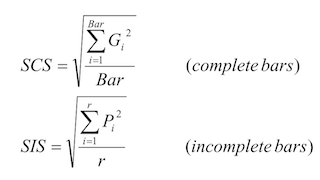
Where Gi and Pi are the ith complete or incomplete segments from any given diagonal, Bar is the bar length, and r is the length of the incomplete segment.
This results in various new ASMs of multiple resolutions depending on the bar_candidate value they are computed with. Each of these ASMs is then given an overall similarity value, in order to find out which bar length produced the ASM with the overall highest similarity: 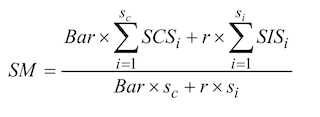
Where sc and si are the number of SCS and SIS segments respectively.

In [23]:
def compute_similarity():
    ref_ASM = squareform(pdist(spectrogram[first_note_flag:]))
    diagonals = {}
    SCS = {}
    SIS = {}
    SM = {}
    for bar in bar_candidates:
        diagonals[bar] = {}
        numb_diagonals = int(ref_ASM.shape[0]/bar)
        for i in range(1, numb_diagonals+1):
            diagonals[bar][i] = list(np.diagonal(ref_ASM, bar*i))
            diagonals[bar][i] = segment_diagonal(diagonals[bar][i], bar)
        SCS[bar] = {}
        SIS[bar] = {}
        for diagonal in range(1, numb_diagonals+1):
            SCS[bar][diagonal] = []
            SIS[bar][diagonal] = []
            for segment in diagonals[bar][diagonal]:
                if len(segment) == bar:
                    SCS[bar][diagonal].append(math.sqrt(sum(list(np.power(segment, 2)))/len(segment)))
                elif len(segment) != bar:
                    SIS[bar][diagonal].append(math.sqrt(sum(list(np.power(segment, 2)))/len(segment)))
        SM[bar] = None
        scsi = 0
        sisi = 0
        sc = 0
        si = 0
        if len(diagonals[bar]) is 0:
            r = 0
        else: 
            r = len(diagonals[bar][1][-1])
        for diagonal in range(1, numb_diagonals+1):
            scsi += sum(SCS[bar][diagonal][:])
            sisi += SIS[bar][diagonal][0]
            sc += len(SCS[bar][diagonal][:])
            si += len(SIS[bar][diagonal][:])
        SM[bar] = (bar*scsi + r*sisi)/(bar*sc + r*si)
    return SM

#### Dataset
Data Set

We use as data set the MagnaTagATune Dataset. Ref:

    Edith Law, Kris West, Michael Mandel, Mert Bay and J. Stephen Downie (2009). Evaluation of algorithms using games: the case of music annotation. In  Proceedings of the 10th International Conference on Music Information Retrieval (ISMIR) http://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset

This data set contains 30s long fragments of tracks. This are annotated by the echonest API with a time signature estimation and it's corresponding confidence. Time signatures can be: 3,4,5 and 7.

From this data set we select a list of fragments by selecting a number songs from every different possible meter matching a tag.

We created a list of 24 different tags in order to have a varied collection of music. From each of these tags we select 3 songs for every available time signature.

The resulting collection has 47 songs. 13 with time signature 3, 33 with time signature 4 and 3 with time signature 7.

#### Filter data from the dataset 
Filter songs by tag to ensure homogeneous representation of styles of music, and also apply a threshold to the timeSignatureConfidence feature from the dataset. From that, return the collection with annotated time signature, confidence, tags, and paths to the audios themselves. The variable num states the maximum number of tracks to get in each tag from each time signature present in the dataset.

In [24]:
path_to_csv = '../annotations_final.csv'
path_to_xml = '../mp3_echonest_xml'
pd_annotations = pd.read_csv(path_to_csv, '\t')

def getTrackCollection(tag='rock', num=1, minConfidence=0.8):
    collection = {}
    for i in range(pd_annotations.shape[1]):
        if pd_annotations[tag][i] == 1:
            xml_track = ET.parse(path_to_xml + '/' + pd_annotations['mp3_path'][i] + '.xml').getroot()
            for child in xml_track:
                if float(child.attrib['timeSignatureConfidence']) >= minConfidence:
                    if child.attrib['timeSignature'] not in collection:
                        collection[child.attrib['timeSignature']] = []
                    if len(collection[child.attrib['timeSignature']]) < num:
                        if float(child.attrib['timeSignatureConfidence']) >= minConfidence:
                            collection[child.attrib['timeSignature']].append({'path': pd_annotations['mp3_path'][i],
                                                                          'timeSignatureConfidence': child.attrib['timeSignatureConfidence'],
                                                                          'tempo':child.attrib['tempo']})    
    return collection

#### Apply method to selected data points in collection

For each track in the extracted collection, the spectrogram is calculated first, then the similarity at various resolutions is computed. It should be noted that, given the limited time signature range of the dataset employed (3, 4, 5, 7), most traditional ternary and binary meters are equalized to either 3 or 4, respectively. If the estimated time signature is 2, 8, or 12, it will be changed to 4, since it is somewhat equivalent in structure (where the tempo and subdivisions may vary). If the estimation is 6 or 9, it will be overwritten to 3, and 10 is changed to 5. Hence the only time signature estimation that will consistently fall out of range in the dataset will be 11, which is inexistent in MagnaTagATune. A measure of confidence in the time signature estimation is calculated as the ratio between the maximum SM (multi-resolution ASM similarity measure) value and the sum of all SM values for ASMs of all bar lengths. This should be representative of how prominent the max SM peak (i.e. the top_candidate) is.

0
4
../mp3/c/lvx_nova-lvx_nova-01-contimune-233-262.mp3
82.4175796508789 bpm,  16000.0 Hz
Frame Size: 364
FFT Size: 512
Padding length: 148
Found first note for frame with E1= 0.09705300629138947 , E2= 1.695224091236014e-05 , and E1/E2= 5725.084181680466
Spectrogram done. Size is (axis1, axis2): (2560, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


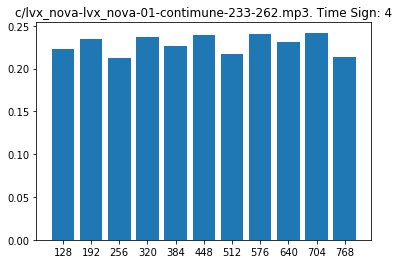

../mp3/0/rocket_city_riot-last_of_the_pleasure_seekers-01-under_the_bright_lights-30-59.mp3
98.03921508789062 bpm,  16000.0 Hz
Frame Size: 306
FFT Size: 512
Padding length: 206
Found first note for frame with E1= 0.13540951907634735 , E2= 1.831291228882037e-05 , and E1/E2= 7394.209994606476
Spectrogram done. Size is (axis1, axis2): (3045, 257)
The estimated time signature is...  12/8
is estimation equal to truth? True


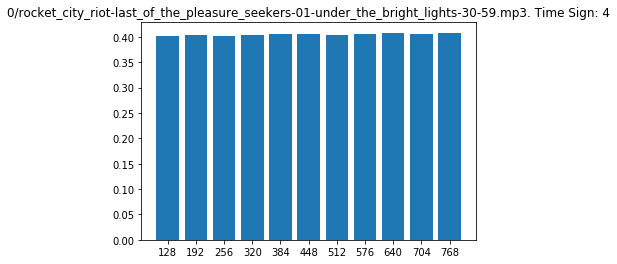

../mp3/0/rocket_city_riot-last_of_the_pleasure_seekers-01-under_the_bright_lights-146-175.mp3
94.93670654296875 bpm,  16000.0 Hz
Frame Size: 316
FFT Size: 512
Padding length: 196
Found first note for frame with E1= 0.2229491025209427 , E2= 0.0003804756561294198 , and E1/E2= 585.9746843963808
Spectrogram done. Size is (axis1, axis2): (2949, 257)
The estimated time signature is...  10/8
is estimation equal to truth? False


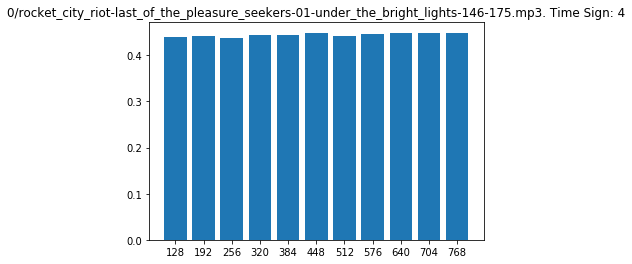

7
../mp3/c/mountain_mirrors-lunar_ecstasy-01-a_short_burst_of_clarity-146-175.mp3
85.2272720336914 bpm,  16000.0 Hz
Frame Size: 352
FFT Size: 512
Padding length: 160
Found first note for frame with E1= 1.7599654711375479e-06 , E2= 1.984807179722381e-10 , and E1/E2= 8867.186138371979
Spectrogram done. Size is (axis1, axis2): (2647, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


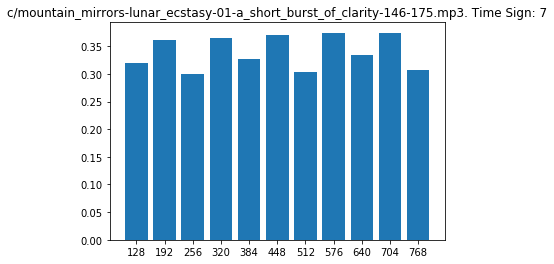

0
3
../mp3/0/american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-117-146.mp3
123.9669418334961 bpm,  16000.0 Hz
Frame Size: 242
FFT Size: 256
Padding length: 14
Found first note for frame with E1= 9.240314824410234e-08 , E2= 1.4515857960084588e-10 , and E1/E2= 636.5669083990119
Spectrogram done. Size is (axis1, axis2): (3851, 129)
The estimated time signature is...  11/8
is estimation equal to truth? False


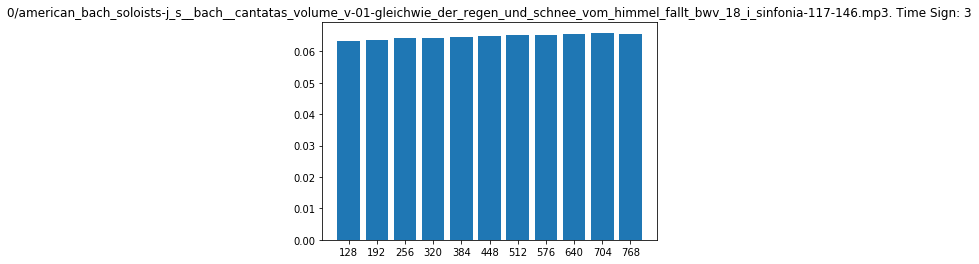

../mp3/9/american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-407-436.mp3
65.78947448730469 bpm,  16000.0 Hz
Frame Size: 456
FFT Size: 512
Padding length: 56
Found first note for frame with E1= 1.3292846290369198e-07 , E2= 1.5740195258295842e-10 , and E1/E2= 844.5159715133284
Spectrogram done. Size is (axis1, axis2): (2043, 257)
The estimated time signature is...  12/8
is estimation equal to truth? False


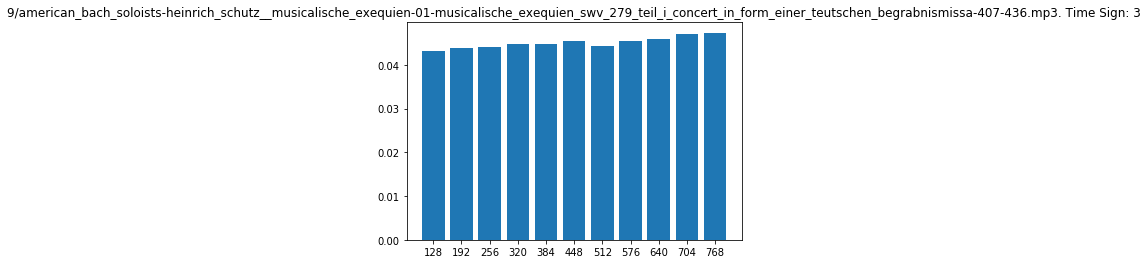

../mp3/9/american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-1248-1277.mp3
122.95082092285156 bpm,  16000.0 Hz
Frame Size: 244
FFT Size: 256
Padding length: 12
Found first note for frame with E1= 1.230417296937958e-07 , E2= 1.1093489321600813e-10 , and E1/E2= 1109.1346115438512
Spectrogram done. Size is (axis1, axis2): (3819, 129)
The estimated time signature is...  12/8
is estimation equal to truth? False


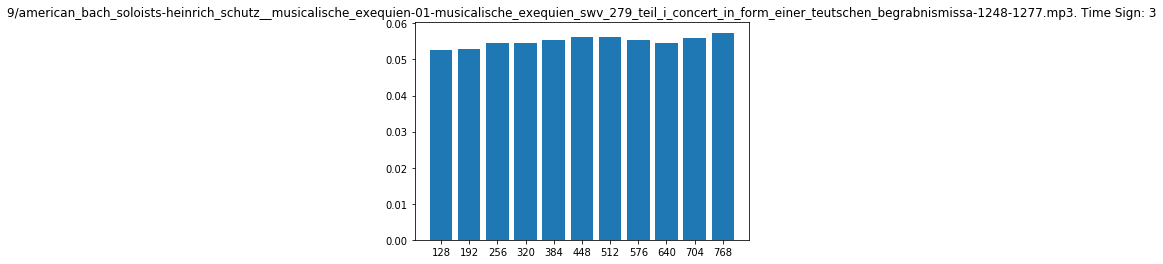

4
../mp3/f/american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-30-59.mp3
127.11864471435547 bpm,  16000.0 Hz
Frame Size: 236
FFT Size: 256
Padding length: 20
Found first note for frame with E1= 0.00063460593810305 , E2= 1.0131708449989674e-06 , and E1/E2= 626.3562964089208
Spectrogram done. Size is (axis1, axis2): (3949, 129)
The estimated time signature is...  12/8
is estimation equal to truth? True


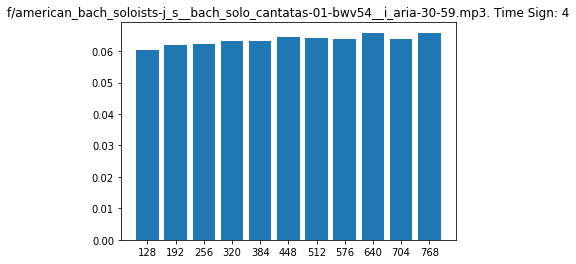

../mp3/f/american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-146-175.mp3
127.11864471435547 bpm,  16000.0 Hz
Frame Size: 236
FFT Size: 256
Padding length: 20
Found first note for frame with E1= 2.1485303136614675e-07 , E2= 1.8100472509718912e-10 , and E1/E2= 1187.0023351643613
Spectrogram done. Size is (axis1, axis2): (3949, 129)
The estimated time signature is...  11/8
is estimation equal to truth? False


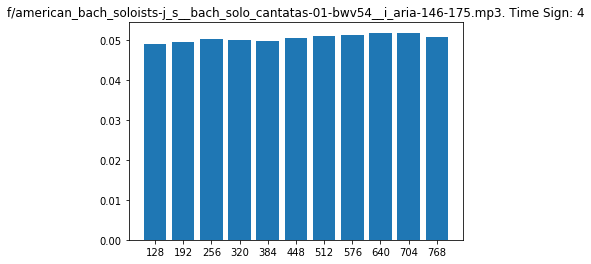

../mp3/f/american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-262-291.mp3
127.11864471435547 bpm,  16000.0 Hz
Frame Size: 236
FFT Size: 256
Padding length: 20
Found first note for frame with E1= 0.006790936924517155 , E2= 5.0915705287479796e-06 , and E1/E2= 1333.7607494925637
Spectrogram done. Size is (axis1, axis2): (3949, 129)
The estimated time signature is...  11/8
is estimation equal to truth? False


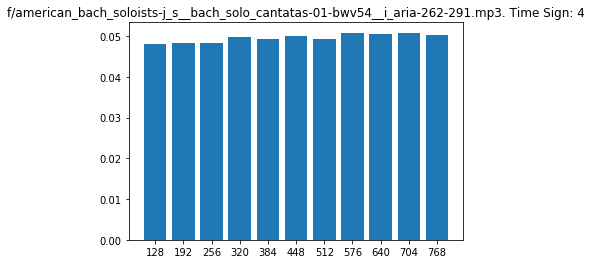

7
../mp3/5/new_york_consort_of_viols-dances_and_canzonas_of_holborne_and_brade-01-3_almaines_holborne-262-291.mp3
72.11538696289062 bpm,  16000.0 Hz
Frame Size: 416
FFT Size: 512
Padding length: 96
Found first note for frame with E1= 4.303638547753508e-07 , E2= 1.8326208606200822e-10 , and E1/E2= 2348.351827828336
Spectrogram done. Size is (axis1, axis2): (2240, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


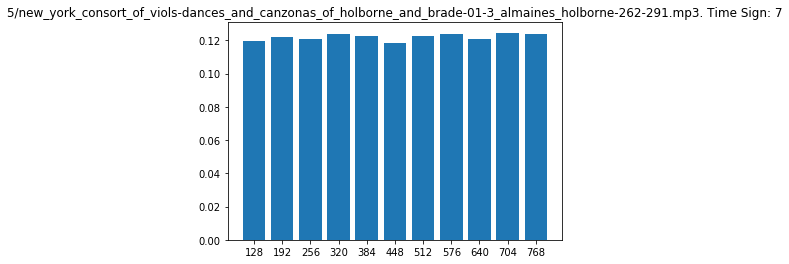

4
../mp3/f/pain_factor-8_seconds-01-8_seconds-59-88.mp3
145.63107299804688 bpm,  16000.0 Hz
Frame Size: 206
FFT Size: 256
Padding length: 50
Found first note for frame with E1= 2.269851620440022e-06 , E2= 1.5854981216811836e-10 , and E1/E2= 14316.331185767562
Spectrogram done. Size is (axis1, axis2): (4524, 129)
The estimated time signature is...  10/8
is estimation equal to truth? False


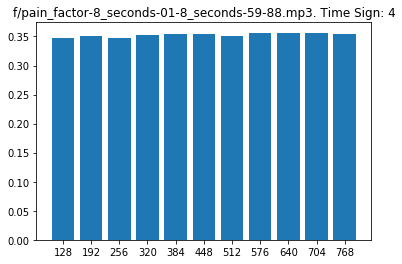

../mp3/f/pain_factor-8_seconds-01-8_seconds-175-204.mp3
145.63107299804688 bpm,  16000.0 Hz
Frame Size: 206
FFT Size: 256
Padding length: 50
Found first note for frame with E1= 0.4271763563156128 , E2= 0.0006445739418268204 , and E1/E2= 662.726692154092
Spectrogram done. Size is (axis1, axis2): (4524, 129)
The estimated time signature is...  11/8
is estimation equal to truth? False


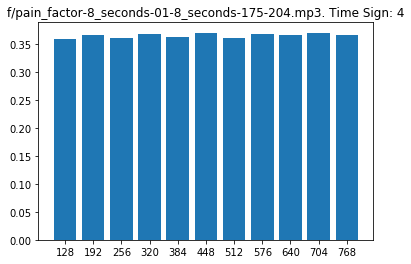

0
4
../mp3/4/justin_bianco-siren-01-another_century-30-59.mp3
100.0 bpm,  16000.0 Hz
Frame Size: 300
FFT Size: 512
Padding length: 212
Found first note for frame with E1= 2.3285180361654056e-07 , E2= 1.975579561053209e-10 , and E1/E2= 1178.6506005984595
Spectrogram done. Size is (axis1, axis2): (3106, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


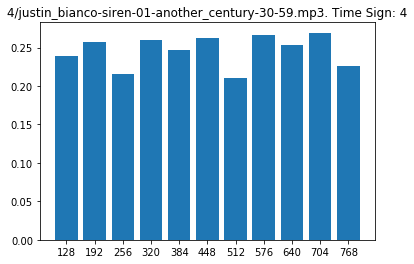

0
3
../mp3/9/american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-30-59.mp3
107.14286041259766 bpm,  16000.0 Hz
Frame Size: 280
FFT Size: 512
Padding length: 232
Found first note for frame with E1= 0.0006900576408952475 , E2= 6.919557815621147e-09 , and E1/E2= 99725.68468716569
Spectrogram done. Size is (axis1, axis2): (3328, 257)
The estimated time signature is...  12/8
is estimation equal to truth? False


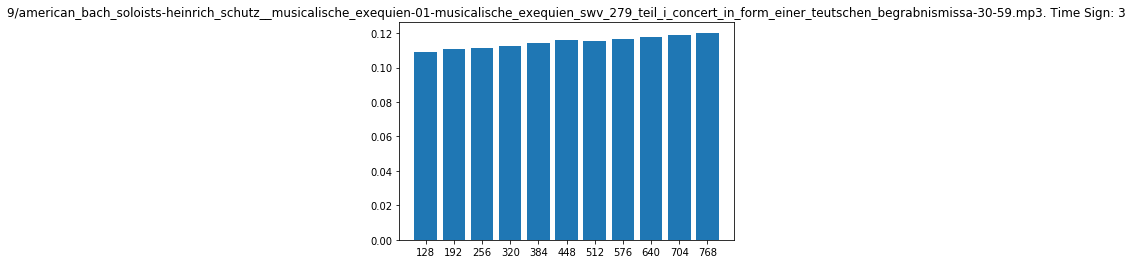

../mp3/9/american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-407-436.mp3
65.78947448730469 bpm,  16000.0 Hz
Frame Size: 456
FFT Size: 512
Padding length: 56
Found first note for frame with E1= 1.3292846290369198e-07 , E2= 1.5740195258295842e-10 , and E1/E2= 844.5159715133284
Spectrogram done. Size is (axis1, axis2): (2043, 257)
The estimated time signature is...  12/8
is estimation equal to truth? False


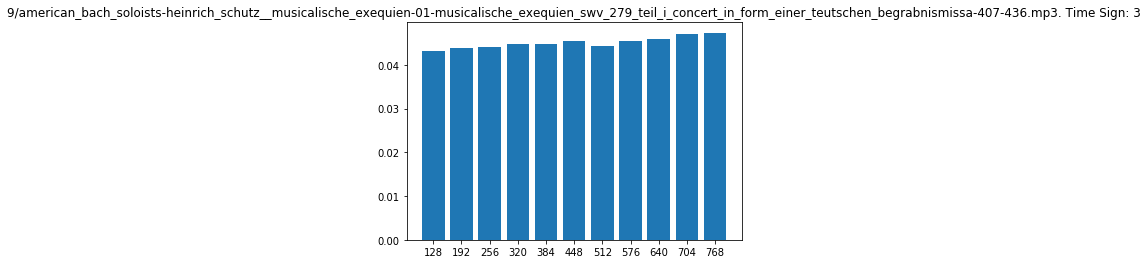

4
../mp3/f/american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-30-59.mp3
127.11864471435547 bpm,  16000.0 Hz
Frame Size: 236
FFT Size: 256
Padding length: 20
Found first note for frame with E1= 0.00063460593810305 , E2= 1.0131708449989674e-06 , and E1/E2= 626.3562964089208
Spectrogram done. Size is (axis1, axis2): (3949, 129)
The estimated time signature is...  12/8
is estimation equal to truth? True


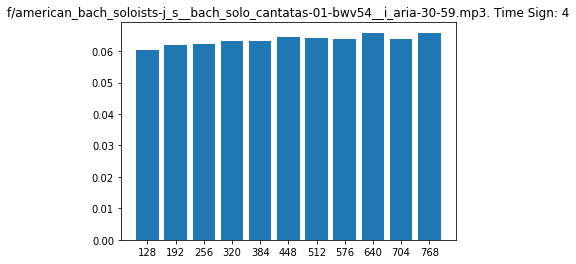

../mp3/f/american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-146-175.mp3
127.11864471435547 bpm,  16000.0 Hz
Frame Size: 236
FFT Size: 256
Padding length: 20
Found first note for frame with E1= 2.1485303136614675e-07 , E2= 1.8100472509718912e-10 , and E1/E2= 1187.0023351643613
Spectrogram done. Size is (axis1, axis2): (3949, 129)
The estimated time signature is...  11/8
is estimation equal to truth? False


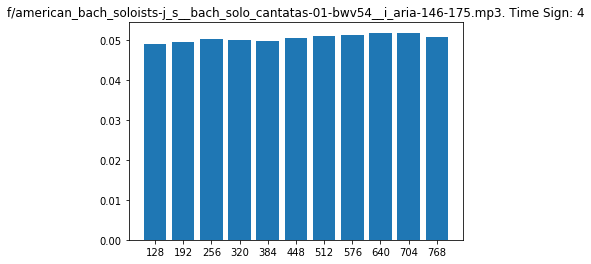

../mp3/f/american_bach_soloists-j_s__bach_solo_cantatas-01-bwv54__i_aria-262-291.mp3
127.11864471435547 bpm,  16000.0 Hz
Frame Size: 236
FFT Size: 256
Padding length: 20
Found first note for frame with E1= 0.006790936924517155 , E2= 5.0915705287479796e-06 , and E1/E2= 1333.7607494925637
Spectrogram done. Size is (axis1, axis2): (3949, 129)
The estimated time signature is...  11/8
is estimation equal to truth? False


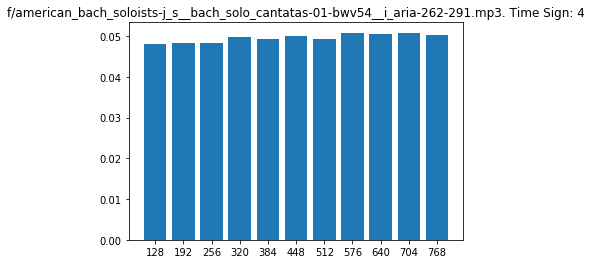

4
../mp3/e/burning_babylon-stereo_mash_up-01-7_nine_skank-175-204.mp3
141.50942993164062 bpm,  16000.0 Hz
Frame Size: 212
FFT Size: 256
Padding length: 44
Found first note for frame with E1= 0.0005537120159715414 , E2= 3.146003457743518e-09 , and E1/E2= 176004.8974544654
Spectrogram done. Size is (axis1, axis2): (4396, 129)
The estimated time signature is...  11/8
is estimation equal to truth? False


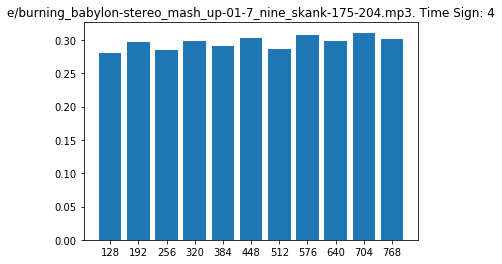

4
../mp3/4/justin_bianco-siren-01-another_century-117-146.mp3
100.0 bpm,  16000.0 Hz
Frame Size: 300
FFT Size: 512
Padding length: 212
Found first note for frame with E1= 1.7690793185920484e-07 , E2= 2.459387415942871e-10 , and E1/E2= 719.3170572167969
Spectrogram done. Size is (axis1, axis2): (3106, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


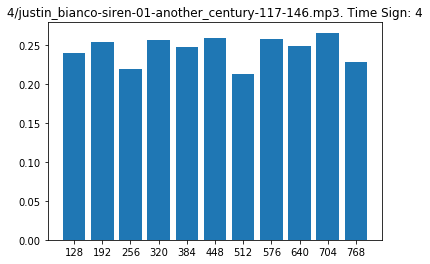

0
3
../mp3/e/steven_devine-portrait_of_an_english_harpsichord-01-lesson_1_in_g_major_prelude_james_nares-0-29.mp3
87.20930480957031 bpm,  16000.0 Hz
Frame Size: 344
FFT Size: 512
Padding length: 168
Found first note for frame with E1= 2.192337404949285e-07 , E2= 3.255955505210295e-10 , and E1/E2= 673.3315002127729
Spectrogram done. Size is (axis1, axis2): (2709, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


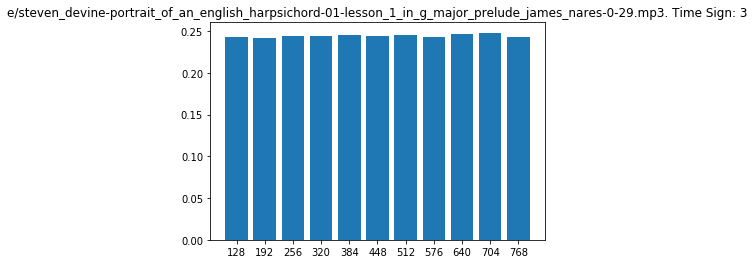

../mp3/8/jacob_heringman-josquin_des_prez_lute_settings-01-anon__praeter_rerum_seriem-262-291.mp3
76.53060913085938 bpm,  16000.0 Hz
Frame Size: 392
FFT Size: 512
Padding length: 120
Found first note for frame with E1= 2.7727151064027566e-07 , E2= 1.5314068069205433e-10 , and E1/E2= 1810.5673122730336
Spectrogram done. Size is (axis1, axis2): (2377, 257)
The estimated time signature is...  9/8
is estimation equal to truth? True


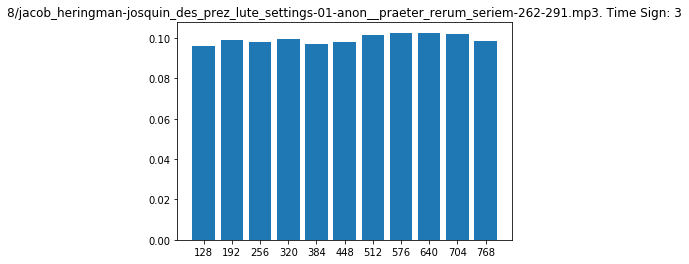

../mp3/c/jamie_janover-now_center_of_time-01-arc-291-320.mp3
78.9473648071289 bpm,  16000.0 Hz
Frame Size: 380
FFT Size: 512
Padding length: 132
Found first note for frame with E1= 7.100879884092137e-07 , E2= 1.8269549761917858e-10 , and E1/E2= 3886.7295454065516
Spectrogram done. Size is (axis1, axis2): (2452, 257)
The estimated time signature is...  7/8
is estimation equal to truth? False


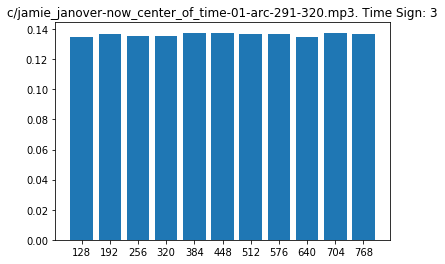

4
../mp3/0/rocket_city_riot-last_of_the_pleasure_seekers-01-under_the_bright_lights-146-175.mp3
94.93670654296875 bpm,  16000.0 Hz
Frame Size: 316
FFT Size: 512
Padding length: 196
Found first note for frame with E1= 0.2229491025209427 , E2= 0.0003804756561294198 , and E1/E2= 585.9746843963808
Spectrogram done. Size is (axis1, axis2): (2949, 257)
The estimated time signature is...  10/8
is estimation equal to truth? False


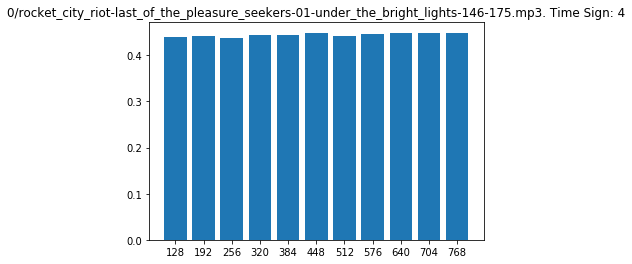

../mp3/6/mercy_machine-the_devil_i_know-01-30_years-262-291.mp3
123.9669418334961 bpm,  16000.0 Hz
Frame Size: 242
FFT Size: 256
Padding length: 14
Found first note for frame with E1= 1.630665428820066e-05 , E2= 1.5560765120881115e-08 , and E1/E2= 1047.9339647842016
Spectrogram done. Size is (axis1, axis2): (3851, 129)
The estimated time signature is...  10/8
is estimation equal to truth? False


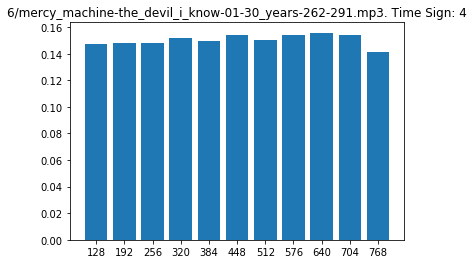

../mp3/f/pain_factor-8_seconds-01-8_seconds-175-204.mp3
145.63107299804688 bpm,  16000.0 Hz
Frame Size: 206
FFT Size: 256
Padding length: 50
Found first note for frame with E1= 0.4271763563156128 , E2= 0.0006445739418268204 , and E1/E2= 662.726692154092
Spectrogram done. Size is (axis1, axis2): (4524, 129)
The estimated time signature is...  11/8
is estimation equal to truth? False


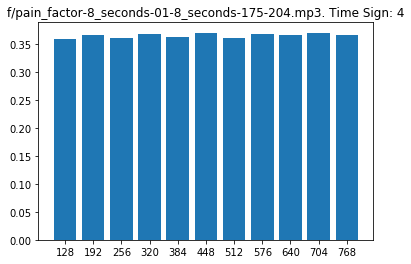

7
../mp3/c/mountain_mirrors-lunar_ecstasy-01-a_short_burst_of_clarity-146-175.mp3
85.2272720336914 bpm,  16000.0 Hz
Frame Size: 352
FFT Size: 512
Padding length: 160
Found first note for frame with E1= 1.7599654711375479e-06 , E2= 1.984807179722381e-10 , and E1/E2= 8867.186138371979
Spectrogram done. Size is (axis1, axis2): (2647, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


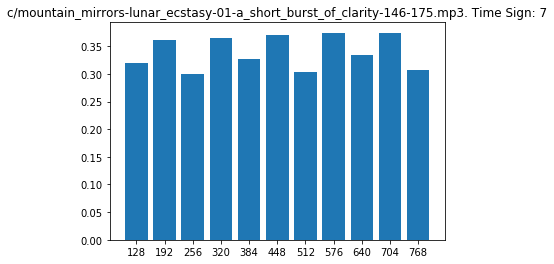

0
4
../mp3/c/lvx_nova-lvx_nova-01-contimune-233-262.mp3
82.4175796508789 bpm,  16000.0 Hz
Frame Size: 364
FFT Size: 512
Padding length: 148
Found first note for frame with E1= 0.09705300629138947 , E2= 1.695224091236014e-05 , and E1/E2= 5725.084181680466
Spectrogram done. Size is (axis1, axis2): (2560, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


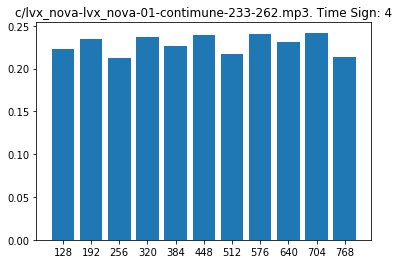

../mp3/c/lvx_nova-lvx_nova-01-contimune-291-320.mp3
82.4175796508789 bpm,  16000.0 Hz
Frame Size: 364
FFT Size: 512
Padding length: 148
Found first note for frame with E1= 0.04663814976811409 , E2= 8.684227395860944e-06 , and E1/E2= 5370.443177287441
Spectrogram done. Size is (axis1, axis2): (2560, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


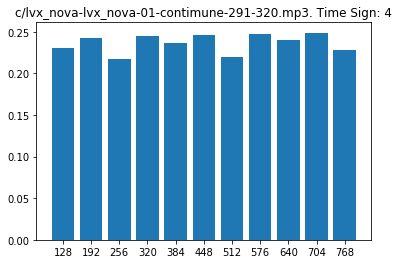

../mp3/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-01-overture-88-117.mp3
123.9669418334961 bpm,  16000.0 Hz
Frame Size: 242
FFT Size: 256
Padding length: 14
Found first note for frame with E1= 0.0015554047422483563 , E2= 2.8048805233993335e-07 , and E1/E2= 5545.351145165023
Spectrogram done. Size is (axis1, axis2): (3851, 129)
The estimated time signature is...  11/8
is estimation equal to truth? False


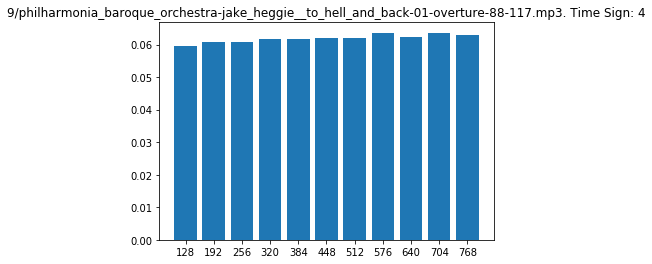

3
../mp3/1/tim_rayborn-ashek-01-ashek-436-465.mp3
81.52173614501953 bpm,  16000.0 Hz
Frame Size: 368
FFT Size: 512
Padding length: 144
Found first note for frame with E1= 0.01631634123623371 , E2= 2.3248840079759248e-05 , and E1/E2= 701.8131304726439
Spectrogram done. Size is (axis1, axis2): (2532, 257)
The estimated time signature is...  10/8
is estimation equal to truth? False


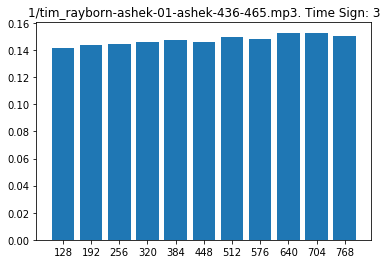

4
../mp3/f/the_headroom_project-jetuton_andawai-01-linda_morena-59-88.mp3
85.2272720336914 bpm,  16000.0 Hz
Frame Size: 352
FFT Size: 512
Padding length: 160
Found first note for frame with E1= 0.02449682727456093 , E2= 4.6591449063271284e-05 , and E1/E2= 525.7794674145933
Spectrogram done. Size is (axis1, axis2): (2647, 257)
The estimated time signature is...  10/8
is estimation equal to truth? False


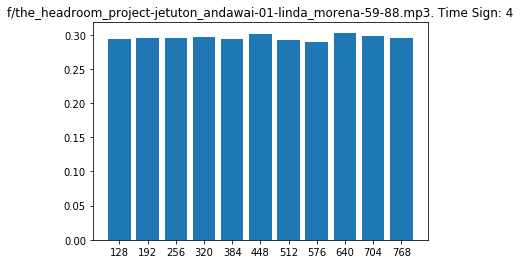

3
../mp3/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-01-overture-117-146.mp3
109.48905181884766 bpm,  16000.0 Hz
Frame Size: 274
FFT Size: 512
Padding length: 238
Found first note for frame with E1= 7.10549329596688e-07 , E2= 4.2368172858964215e-10 , and E1/E2= 1677.0827761725172
Spectrogram done. Size is (axis1, axis2): (3401, 257)
The estimated time signature is...  10/8
is estimation equal to truth? False


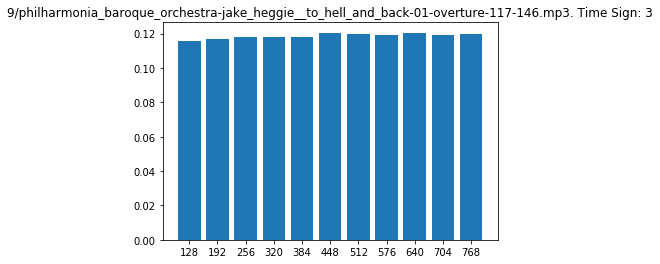

4
../mp3/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-01-overture-59-88.mp3
118.11023712158203 bpm,  16000.0 Hz
Frame Size: 254
FFT Size: 256
Padding length: 2
Found first note for frame with E1= 8.583756994084979e-08 , E2= 1.2649491176741634e-10 , and E1/E2= 678.5851599997762
Spectrogram done. Size is (axis1, axis2): (3669, 129)
The estimated time signature is...  11/8
is estimation equal to truth? False


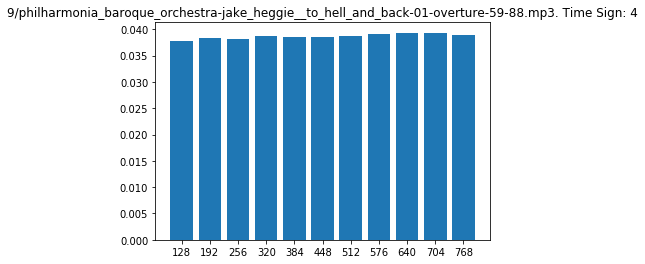

../mp3/9/philharmonia_baroque_orchestra-jake_heggie__to_hell_and_back-01-overture-88-117.mp3
123.9669418334961 bpm,  16000.0 Hz
Frame Size: 242
FFT Size: 256
Padding length: 14
Found first note for frame with E1= 0.0015554047422483563 , E2= 2.8048805233993335e-07 , and E1/E2= 5545.351145165023
Spectrogram done. Size is (axis1, axis2): (3851, 129)
The estimated time signature is...  11/8
is estimation equal to truth? False


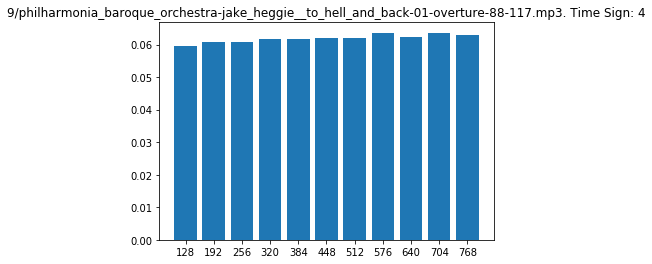

3
../mp3/c/jamie_janover-now_center_of_time-01-arc-291-320.mp3
78.9473648071289 bpm,  16000.0 Hz
Frame Size: 380
FFT Size: 512
Padding length: 132
Found first note for frame with E1= 7.100879884092137e-07 , E2= 1.8269549761917858e-10 , and E1/E2= 3886.7295454065516
Spectrogram done. Size is (axis1, axis2): (2452, 257)
The estimated time signature is...  7/8
is estimation equal to truth? False


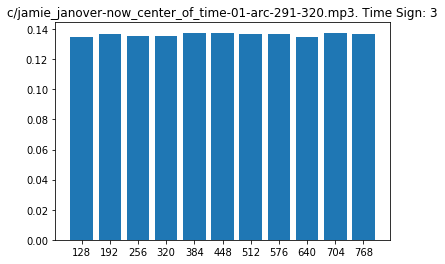

../mp3/c/jamie_janover-now_center_of_time-01-arc-436-465.mp3
156.25 bpm,  16000.0 Hz
Frame Size: 192
FFT Size: 256
Padding length: 64
Found first note for frame with E1= 2.916356152127264e-07 , E2= 1.7233496574231566e-10 , and E1/E2= 1692.2602674189484
Spectrogram done. Size is (axis1, axis2): (4853, 129)
The estimated time signature is...  9/8
is estimation equal to truth? True


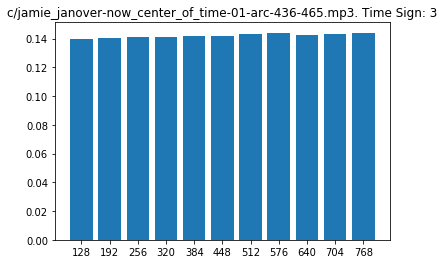

4
../mp3/6/mercy_machine-the_devil_i_know-01-30_years-262-291.mp3
123.9669418334961 bpm,  16000.0 Hz
Frame Size: 242
FFT Size: 256
Padding length: 14
Found first note for frame with E1= 1.630665428820066e-05 , E2= 1.5560765120881115e-08 , and E1/E2= 1047.9339647842016
Spectrogram done. Size is (axis1, axis2): (3851, 129)
The estimated time signature is...  10/8
is estimation equal to truth? False


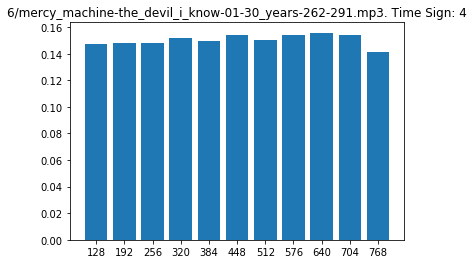

../mp3/4/justin_bianco-siren-01-another_century-175-204.mp3
100.0 bpm,  16000.0 Hz
Frame Size: 300
FFT Size: 512
Padding length: 212
Found first note for frame with E1= 0.011281756684184074 , E2= 9.00235590961529e-06 , and E1/E2= 1253.2004730155347
Spectrogram done. Size is (axis1, axis2): (3106, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


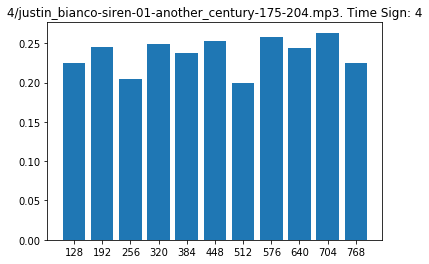

0
0
4
../mp3/1/ambient_teknology-phoenix-01-ambient_teknology-0-29.mp3
70.09346008300781 bpm,  16000.0 Hz
Frame Size: 428
FFT Size: 512
Padding length: 84
Found first note for frame with E1= 0.6818920969963074 , E2= 0.0011740745976567268 , and E1/E2= 580.7911169846103
Spectrogram done. Size is (axis1, axis2): (2177, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


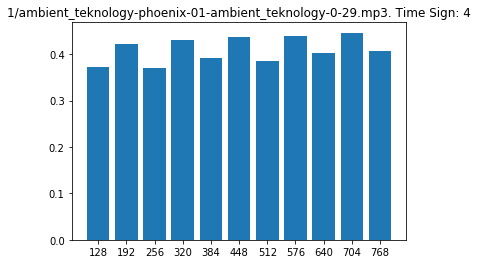

../mp3/1/ambient_teknology-phoenix-01-ambient_teknology-146-175.mp3
70.09346008300781 bpm,  16000.0 Hz
Frame Size: 428
FFT Size: 512
Padding length: 84
Found first note for frame with E1= 1.9717947452591034e-07 , E2= 1.7757871562107397e-10 , and E1/E2= 1110.377861650162
Spectrogram done. Size is (axis1, axis2): (2177, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


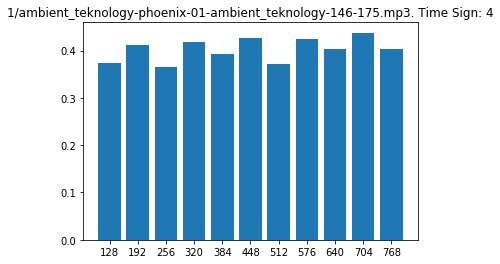

../mp3/1/ambient_teknology-phoenix-01-ambient_teknology-407-436.mp3
70.09346008300781 bpm,  16000.0 Hz
Frame Size: 428
FFT Size: 512
Padding length: 84
Found first note for frame with E1= 9.47219859881443e-07 , E2= 1.315021841419295e-10 , and E1/E2= 7203.073211765931
Spectrogram done. Size is (axis1, axis2): (2177, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


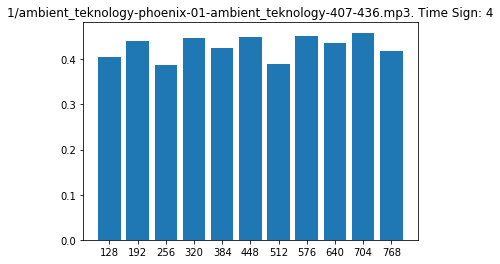

3
../mp3/e/burning_babylon-stereo_mash_up-01-7_nine_skank-146-175.mp3
70.75471496582031 bpm,  16000.0 Hz
Frame Size: 424
FFT Size: 512
Padding length: 88
Found first note for frame with E1= 1.6168544334504986e-06 , E2= 2.1710006015140948e-10 , and E1/E2= 7447.507993884826
Spectrogram done. Size is (axis1, axis2): (2198, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


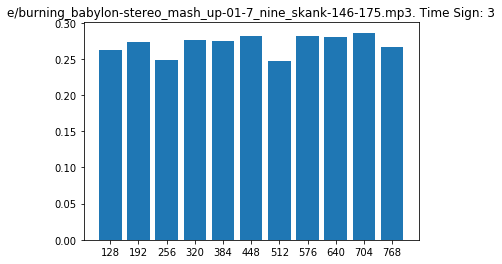

4
../mp3/c/lvx_nova-lvx_nova-01-contimune-30-59.mp3
82.4175796508789 bpm,  16000.0 Hz
Frame Size: 364
FFT Size: 512
Padding length: 148
Found first note for frame with E1= 0.017826903611421585 , E2= 3.81747258870746e-06 , and E1/E2= 4669.818367302936
Spectrogram done. Size is (axis1, axis2): (2560, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


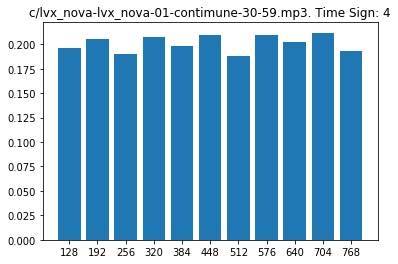

../mp3/0/williamson-a_few_things_to_hear_before_we_all_blow_up-01-2_percent_er-117-146.mp3
79.7872314453125 bpm,  16000.0 Hz
Frame Size: 376
FFT Size: 512
Padding length: 136
Found first note for frame with E1= 0.22494325041770935 , E2= 0.0003733572084456682 , and E1/E2= 602.4880337898809
Spectrogram done. Size is (axis1, axis2): (2478, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


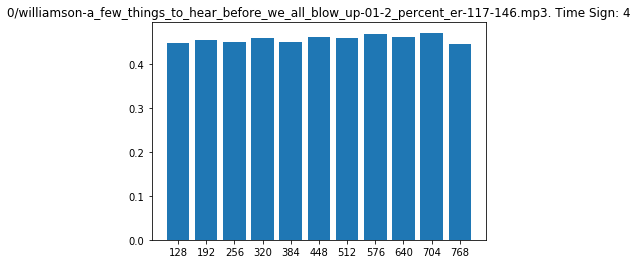

../mp3/a/liquid_zen-magic_midsummer-01-4_oclock_sunny_and_hot-30-59.mp3
128.2051239013672 bpm,  16000.0 Hz
Frame Size: 234
FFT Size: 256
Padding length: 22
Found first note for frame with E1= 2.203955205004604e-07 , E2= 1.2499183632552757e-10 , and E1/E2= 1763.2793227108398
Spectrogram done. Size is (axis1, axis2): (3982, 129)
The estimated time signature is...  11/8
is estimation equal to truth? False


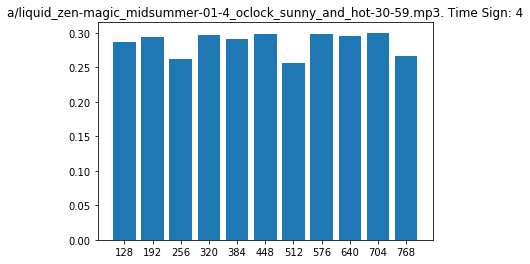

4
../mp3/4/justin_bianco-siren-01-another_century-30-59.mp3
100.0 bpm,  16000.0 Hz
Frame Size: 300
FFT Size: 512
Padding length: 212
Found first note for frame with E1= 2.3285180361654056e-07 , E2= 1.975579561053209e-10 , and E1/E2= 1178.6506005984595
Spectrogram done. Size is (axis1, axis2): (3106, 257)
The estimated time signature is...  11/8
is estimation equal to truth? False


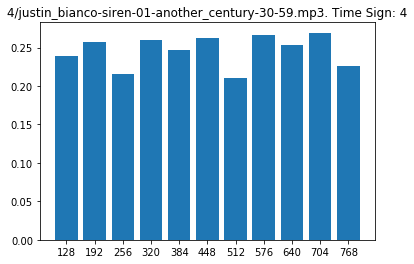

In [25]:
tags = ['rock', 'classical', 'heavy', 'jazz', 'opera','funk', 'funky', 'electronica', 'guitar', 'folk', 'fast', 'irish',
       'arabic', 'instrumental', 'spanish', 'orchestra', 'piano', 'celtic', 'woman', 'dance', 'techno', 'hip hop']
results_dict = {"tag": [], "song":[], "original_ts":[], "conf_original_ts":[], "estimated_ts":[],
                "conf_estimated_ts":[], "equal":[]}

for tag in tags:
    for timeSig, paths in getTrackCollection(tag, 3, 0.8).items():
        print(timeSig)
        if int(timeSig) == 0:
            continue
        for path in paths:
            full_path = path_to_data_set + path['path']
            print(full_path)
            audioInput, bpm, fs = get_audio_and_tempo(full_path)
            spectrogram, db_spectrogram, fft_size, hop_size, first_note_flag = compute_spectrogram(path)
            SM = compute_similarity()

            top_candidate = list(SM.keys())[list(SM.values()).index(max(list(SM.values())))] / 64
            if top_candidate == 2:
                time_signature = '{}/2'.format(int(top_candidate))
                print('The estimated time signature is... ', time_signature)
                top_candidate = 4
            elif top_candidate > 2 and top_candidate < 6:
                time_signature = '{}/4'.format(int(top_candidate))
                print('The estimated time signature is... ', time_signature)
            else:
                time_signature = '{}/8'.format(int(top_candidate))
                print('The estimated time signature is... ', time_signature)
                if top_candidate == 8 or top_candidate == 12:
                    top_candidate = 4
                elif top_candidate == 6 or top_candidate == 9:
                    top_candidate = 3
                elif top_candidate == 10:
                    top_candidate = 5

            confidence = max(list(SM.values())) / sum(list(SM.values()))

            print("is estimation equal to truth? " + str(int(timeSig) == int(top_candidate)))

            ordered_SM = OrderedDict(sorted(SM.items()))
            plt.bar(range(len(ordered_SM)), list(ordered_SM.values()), align='center')
            xlabels = list(ordered_SM.keys())
            plt.title(path['path'] + ". Time Sign: " + timeSig)
            plt.xticks(range(len(ordered_SM)), xlabels)
            plt.show()

            results_dict["tag"].append(tag)
            results_dict["song"].append(path['path'])
            results_dict["original_ts"].append(timeSig)
            results_dict["conf_original_ts"].append(path['timeSignatureConfidence'])
            results_dict["estimated_ts"].append(int(top_candidate))
            results_dict["conf_estimated_ts"].append(confidence)
            results_dict["equal"].append(int(timeSig) == int(top_candidate))

            

#### Results
Time signature (TS) is represented as an integer number of beats per bar, not a fraction.
Show results as: track number, estimated TS confidence, dataset TS confidence, equality measure, estimated TS, and annotated time signature (original_ts).
Shows selected dataset collection as: track number, associated tag, path to file.

In [26]:
df_results = pd.DataFrame(results_dict)
print(df_results)

    conf_estimated_ts conf_original_ts  equal  estimated_ts original_ts  \
0            0.096133            1.000  False            11           4   
1            0.091628            1.000   True             4           4   
2            0.091840            1.000  False            10           4   
3            0.100167            1.000  False            11           7   
4            0.092548            1.000  False            11           3   
5            0.095368            1.000  False             4           3   
6            0.094786            1.000  False             4           3   
7            0.094199            0.978   True             4           4   
8            0.093275            1.000  False            11           4   
9            0.093255            0.928  False            11           4   
10           0.092777            1.000  False            11           7   
11           0.091848            0.949  False            10           4   
12           0.092109    

#### Evaluation

The papers evaluation method is rather poor. It relies merely on a binary Correct Time Signature (CTS) metric, for a set of only 12 songs, more or less one for each time signature considered. Authors write of the "robustness of the time signature detector" with such a reduced test set. Additionally, their representation of SM values (their Figures 6 and 7) for two of the songs in the test set is confusing. In theory only integer multiples of the beat_duration are considered as bar length candidates in the algorithm, but their graphs show peaks for SM in between integer values, and no explanation is provided as to how such representations (or any other data visualisation in the paper, for that matter) are derived.